# CNN SEGMENT

Authors:</br>
Alberto Padilla Nieto </br>
Marco Antonio Hernani Chavez </br>

The objective of this notebook is to create a CNN model that is able to classify the emotion from a given stimuli.

# CPU or GPU 

We choose if We want to use the CPU or the GPU to train the model

In [1]:
import tensorflow as tf
# # TensorFlow configuration to use the GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

tf.config.set_visible_devices([], 'GPU')

# LIBRARIES 

In [11]:
# We import the specialized library to manipulate raw EEG data
import mne

# Library to use operative system functions
import os
import numpy as np

#Libraries to control the execution time
from tqdm import tqdm
import time

# Libraries to do Statistics
import scipy.stats
import random
from scipy.stats import entropy
from scipy.fft import fft
from scipy.signal import welch
from scipy.stats import mstats

# Libraries to create and train the CNN model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

# Libraries to make the graphics
import matplotlib.pyplot as plt
import seaborn as sns

# No Warning
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("ERROR")

In [3]:
os.getcwd()

'C:\\Users\\macka\\TFM_WD\\ORI\\SEEDs_FIF_RECOG_GAN'

# Segment creation

Using the preprocessed data, We create segments by following the process specified in the (Bands Frequencies - Position and Signals by Channels - DE - PSD): https://link.springer.com/article/10.1007/s11571-021-09751-5 </br>
For this process, the data is divided into 4-second segments, a bandpass filter is applied to the data of each segment for each frequency band, and the power spectral density (PSD) is calculated for each frequency band and the differential entropy (DE) for each channel of the EEG signal in that frequency band. Next, create a 2D matrix that represents the spatial distribution of the PSD and DE in each frequency band, for each 4-second segment. Finally, the data is stored in a list of segments for further processing.

This process is repeated for each emotion (positive, negative and neutral)

## Constant to create segment

In [6]:
# Bands Frequencies: Names and ranges
freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30],
              'gamma': [30, 52]}


# Window Size to create object 4D
win_sec = 2

# Assuming a fixed height and width (19x19 in this case)
height, width = 19, 19

# Define the number of num_maps based on the number of EEG num_maps
num_maps = len(freq_bands) * 2 

# Define an map full zeros.
sparse_map = np.zeros((height, width))

In [ ]:
def gaussian_entropy(std_deviation):
    """
    Calculate the differential entropy for a Gaussian distribution.
    param std_deviation: standard deviation of the signal.
    return: differential entropy.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

## Segments Positives

In [7]:
start_time = time.time()  # Record the start time
# Path
emotion = 'POSITIVE'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# Prints the name of the files
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

# Storage Data
psd_pos_data = {}

psd_pos_2d={}
de_pos_2d={}

segment_psd_pos={}
segment_de_pos={}

segment_pos=[]
segment_pos_list=[]

input_data_pos = []

# Loads the files and creates the segments
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # The path to the file that contains the EEG is defined
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Load EEG data
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Define sampling frequency
    sfreq = eeg_data.info['sfreq']

    # Define window characteristics (4 seconds)
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
       
    # Create window
    # Iterate through each window and apply bandpass filter to EEG data for each frequency band
    for i in range(total_windows): # 1=total_windows
        
        # Obtain EEG data for the current window
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Create frequency bands for EACH WINDOW
        # Apply bandpass filter to EEG data for each frequency band
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calculate PSD using MNE's 'psd_welch' function
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_pos_data[band_name] = psd
   
            for key, value in psd_pos_data.items():
                segment_psd_pos[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calculate differential entropy for each channel in the current frequency band
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_pos:
                    segment_de_pos[band_name] = [de]  # Create a new array with the first value of 'de'
                else:
                    segment_de_pos[band_name].append(de)  # Append the value of 'de' to the end of the existing array
        # 2D PSD Matrix           
        for band_name, values in segment_psd_pos.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_pos_2d[band_name]=sparse_map
        # 2D DE Matrix    
        for band_name, values in segment_de_pos.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_pos_2d[band_name]=sparse_map
        
        # Segment creation
        segment_pos.append([de_pos_2d,psd_pos_2d])
        segment_pos_list.append(segment_pos)
        
elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Time: 3.20 H


## Create Input 4D - (nºsegments,height,width,channels)

In [24]:
start_time = time.time()  # Record the start time

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_pos_list)

# Initialize the 4D input with zeros
input_4d_pos = np.zeros((num_segment, height, width, num_maps))

for i, segment in tqdm(enumerate(segment_pos_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                 # Data flattening
                current_feature_data_flat = current_feature_data[band_name].flatten()

                # Winsorizing application
                current_feature_data_winsorized = mstats.winsorize(current_feature_data_flat, limits=[0.01, 0.01])

                # Reshape the data back to original form
                current_feature_data_winsorized = current_feature_data_winsorized.reshape(current_feature_data[band_name].shape)

                # Assign the winsorized data to the input matrix
                input_4d_pos[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data_winsorized[y, x]
                
print(f"4D input shape: {input_4d_pos.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")


4D input shape: (51648, 19, 19, 10)
Time: 0.38 H


## Segments Neutral

In [8]:
start_time = time.time()  # Record the start time
# Ruta
emotion = 'NEUTRAL'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# Prints the name of the files
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

# Data Storage
psd_neu_data = {}

psd_neu_2d={}
de_neu_2d={}

segment_psd_neu={}
segment_de_neu={}

segment_neu=[]
segment_neu_list=[]

input_data_neu=[]

# Loads the files and creates the segments
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # The path to the file that contains the EEG is defined
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Load EEG data
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Define sampling frequency
    sfreq = eeg_data.info['sfreq']

    # Define window characteristics (4 seconds)
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
      
    # Create window
    # Iterate through each window and apply bandpass filter to EEG data for each frequency band
    for i in range(total_windows): # 1=total_windows
        
        # Obtain EEG data for the current window
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Create frequency bands for EACH WINDOW
        # Apply bandpass filter to EEG data for each frequency band
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calculate PSD using MNE's 'psd_welch' function
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_neu_data[band_name] = psd
   
            for key, value in psd_neu_data.items():
                segment_psd_neu[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calculate differential entropy for each channel in the current frequency band
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_neu:
                    segment_de_neu[band_name] = [de]  # Create a new array with the first value of 'de'
                else:
                    segment_de_neu[band_name].append(de)  # Append the value of 'de' to the end of the existing array
        # 2D PSD Matrix          
        for band_name, values in segment_psd_neu.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_neu_2d[band_name]=sparse_map
        # 2D DE Matrix
        for band_name, values in segment_de_neu.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_neu_2d[band_name]=sparse_map
        
        # Segment creation
        segment_neu.append([de_neu_2d,psd_neu_2d])
        segment_neu_list.append(segment_neu)

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Time: 2.40 H


## Create Input 4D - (nºsegments,height,width,channels)

In [25]:
start_time = time.time()  # Record the start time
# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_neu_list)

# Initialize the 4D input with zeros
input_4d_neu = np.zeros((num_segment, height, width, num_maps))

for i, segment in tqdm(enumerate(segment_neu_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                 # Data flattening
                current_feature_data_flat = current_feature_data[band_name].flatten()

                # Winsorizing application
                current_feature_data_winsorized = mstats.winsorize(current_feature_data_flat, limits=[0.01, 0.01])

                # Reshape the data back to original form
                current_feature_data_winsorized = current_feature_data_winsorized.reshape(current_feature_data[band_name].shape)

                # Assign the winsorized data to the input matrix
                input_4d_neu[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data_winsorized[y, x]
print(f"4D input shape: {input_4d_neu.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

4D input shape: (55376, 19, 19, 10)
Time: 0.39 H


## Segments Negatives

In [9]:
start_time = time.time()  # Record the start time
# Path
emotion ='NEGATIVE'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# Prints the name of the files
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

#Data Storage
psd_neg_data = {}

psd_neg_2d={}
de_neg_2d={}

segment_psd_neg={}
segment_de_neg={}

psd_list=[]
de_list=[]

segment_neg=[]
segment_neg_list=[]

input_data_neg=[]

# Load and creation of the segment for each file 
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # The path to the file that contains the EEG is defined
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Load EEG data
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Define sampling frequency
    sfreq = eeg_data.info['sfreq']

    # Define window characteristics (4 seconds)
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
         
    # Create window
    # Iterate through each window and apply bandpass filter to EEG data for each frequency band
    for i in range(total_windows): # 1=total_windows
        
        # Obtain EEG data for the current window
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Create frequency bands for EACH WINDOW
        # Apply bandpass filter to EEG data for each frequency band
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calculate PSD using MNE's 'psd_welch' function
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_neg_data[band_name] = psd
   
            for key, value in psd_neg_data.items():
                segment_psd_neg[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calculate differential entropy for each channel in the current frequency band
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_neg:
                    segment_de_neg[band_name] = [de]  # Create a new array with the first value of 'de'
                else:
                    segment_de_neg[band_name].append(de)  # Append the value of 'de' to the end of the existing array
                    
        # 2D PSD Matrix         
        for band_name, values in segment_psd_neg.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_neg_2d[band_name]=sparse_map
        # 2D DE Matrix    
        for band_name, values in segment_de_neg.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_neg_2d[band_name]=sparse_map
        
        # Segment creation
        segment_neg.append([de_neg_2d,psd_neg_2d])
        segment_neg_list.append(segment_neg)
        
elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Time: 2.84 H


## Create Input 4D - (nºsegments,height,width,channels)

In [26]:
start_time = time.time()  # Record the start time

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_neg_list)

# Define the number of num_maps based on the number of EEG num_maps
num_maps = len(freq_bands) * 2 

# Initialize the 4D input with zeros
input_4d_neg = np.zeros((num_segment, height, width, num_maps))

for i, segment in tqdm(enumerate(segment_neg_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
 # Data flattening
                current_feature_data_flat = current_feature_data[band_name].flatten()

                # Winsorizing aplication
                current_feature_data_winsorized = mstats.winsorize(current_feature_data_flat, limits=[0.01, 0.01])

                # Reshape the data back to original form
                current_feature_data_winsorized = current_feature_data_winsorized.reshape(current_feature_data[band_name].shape)

                # Assign the winsorized data to the input matrix
                input_4d_neg[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data_winsorized[y, x]
print(f"4D input shape: {input_4d_neg.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

4D input shape: (62288, 19, 19, 10)
Time: 0.44 H


# Reconocimiento de emociones

Once We have the data in segments We use those segments to create the data for training our model and the data to test our model.

In [27]:
# Concatenate the 4D inputs for each emotion
X = np.concatenate([input_4d_pos, input_4d_neu, input_4d_neg], axis=0)
X_standardized = (X - X.mean()) / X.std()

# Create labels for each emotion
# # Assuming the labels are 2 for positive, 1 for neutral, and 0 for negative
y_positive = np.full((input_4d_pos.shape[0],), 1, dtype=int)
y_neutral = np.full((input_4d_neu.shape[0],), 0, dtype=int)
y_negative = np.full((input_4d_neg.shape[0],), -1, dtype=int)

# Concatenate the labels
y = np.concatenate([y_positive,y_neutral, y_negative], axis=0) 

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state= 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

print(f'X (train/test/val):{len(X_train)},{len(X_test)},{len(X_val)} -- y (train/test/val):{len(y_train)},{len(y_test)},{len(y_val)}')

X (train/test/val):135618,16932,16762 -- y (train/test/val):135618,16932,16762


## Model 1 

We create the CNN model and train it.

In [28]:
def build_CNN_model1(input_shape, num_classes):
        

    model1 = Sequential()

    model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Flatten())

    model1.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))

    model1.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))

    model1.add(Dense(num_classes, activation='softmax'))

    model1.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model1

l2_reg = 0.001
input_shape = X_train.shape[1:]
num_classes = 3

model1 = build_CNN_model1(input_shape, num_classes)

start_time = time.time()

In [32]:
epochs = 20
batch_size = 32

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
history = model1.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_onehot))

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Epoch 1/20
4239/4239 [==============================] - 71s 17ms/step - loss: 1.1069 - accuracy: 0.3616 - val_loss: 1.1105 - val_accuracy: 0.3674
Epoch 2/20
4239/4239 [==============================] - 76s 18ms/step - loss: 1.1085 - accuracy: 0.3619 - val_loss: 1.1045 - val_accuracy: 0.3674
Epoch 3/20
4239/4239 [==============================] - 78s 18ms/step - loss: 1.1075 - accuracy: 0.3627 - val_loss: 1.1038 - val_accuracy: 0.3674
Epoch 4/20
4239/4239 [==============================] - 76s 18ms/step - loss: 1.1080 - accuracy: 0.3605 - val_loss: 1.1113 - val_accuracy: 0.3674
Epoch 5/20
4239/4239 [==============================] - 75s 18ms/step - loss: 1.1068 - accuracy: 0.3626 - val_loss: 1.1086 - val_accuracy: 0.3674
Epoch 6/20
4239/4239 [==============================] - 75s 18ms/step - loss: 1.1086 - accuracy: 0.3619 - val_loss: 1.1066 - val_accuracy: 0.3674
Epoch 7/20
4239/4239 [==============================] - 75s 18ms/step - loss: 1.1077 - accuracy: 0.3611 - val_loss: 1.1053 -

Once is trained We can see that the accuracy with the test data that We reach is of 37.24. Which is low.

In [33]:
accuracy_train = model1.history.history['accuracy'][-1]
loss0, accuracy_test = model1.evaluate(X_test, y_test_onehot)

print(f'ACC. TEST: {accuracy_test} -- ACC. TRAIN: {accuracy_train} ')

530/530 [==============================] - 3s 6ms/step - loss: 1.0998 - accuracy: 0.3725
ACC. TEST: 0.37248995900154114 -- ACC. TRAIN: 0.36254775524139404 


Finally We make a visualization of how the accuracy of the training and validation set change through the training.
We do a similar visualization for the loss.

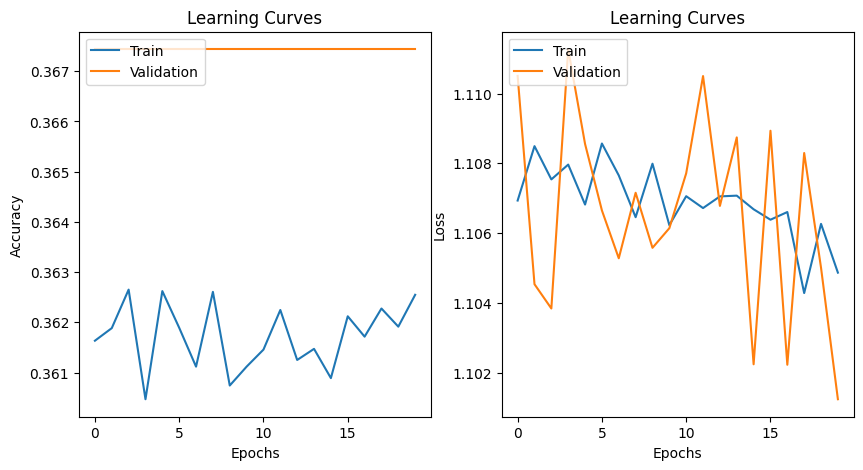

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# To visualize the accuracy of training and validation over time
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Learning Curves')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend(['Train', 'Validation'], loc='upper left')


# Visualize the loss of training and validation over time
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Learning Curves')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend(['Train', 'Validation'], loc='upper left')
fig.show()